# Fault-Tolerant Quantum Key Distribution

In [38]:
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.quil import address_qubits, get_default_qubit_mapping
from pyquil.quilatom import QubitPlaceholder
from pyquil.api import QVMConnection
import numpy as np 
import uuid
import matplotlib.pyplot as plt
%matplotlib inline
qvm = QVMConnection()

## Steane Code
### Implementation

In [ ]:
# create ancilla qubits to be reused throughout
ancillas = [QubitPlaceholder(), QubitPlaceholder(), QubitPlaceholder()]
def reset_ancillas() -> Program:
    prog = Program()
    scratch = prog.declare("scratch" + str(uuid.uuid1()), 'BIT', 3)
    for i, ancilla in enumerate(ancillas):
        prog += MEASURE(ancilla, scratch[i])

        prog.if_then(scratch[i], X(ancilla))

    return prog

# a LogicalQubit is a single qubit encoded using the Steane code
class LogicalQubit:
    def __init__(self):
        self.register = [QubitPlaceholder() for i in range(6)]

    def encode(self, qubit):
        self.register = [qubit] + self.register
        prog = Program()
        prog += H(self.register[4])
        prog += H(self.register[5])
        prog += H(self.register[6])
        prog += CNOT(self.register[0], self.register[1])
        prog += CNOT(self.register[0], self.register[2])
        prog += CNOT(self.register[6], self.register[0])
        prog += CNOT(self.register[6], self.register[1])
        prog += CNOT(self.register[6], self.register[3])
        prog += CNOT(self.register[5], self.register[0])
        prog += CNOT(self.register[5], self.register[2])
        prog += CNOT(self.register[5], self.register[3])
        prog += CNOT(self.register[4], self.register[1])
        prog += CNOT(self.register[4], self.register[2])
        prog += CNOT(self.register[4], self.register[3])
        return prog
    
    def decode(self):
        prog = Program()
        prog += CNOT(self.register[4], self.register[3])
        prog += CNOT(self.register[4], self.register[2])
        prog += CNOT(self.register[4], self.register[1])
        prog += CNOT(self.register[5], self.register[3])
        prog += CNOT(self.register[5], self.register[2])
        prog += CNOT(self.register[5], self.register[0])
        prog += CNOT(self.register[6], self.register[3])
        prog += CNOT(self.register[6], self.register[1])
        prog += CNOT(self.register[6], self.register[0])
        prog += CNOT(self.register[0], self.register[2])
        prog += CNOT(self.register[0], self.register[1])
        prog += H(self.register[6])
        prog += H(self.register[5])
        prog += H(self.register[4])
        return prog, self.register[0]

    def measure(self, targetQubit):
        prog = Program()
        prog += CNOT(self.register[2], targetQubit)
        prog += CNOT(self.register[1], targetQubit)
        prog += CNOT(self.register[0], targetQubit)
        return prog

    def apply_error(self):
        prog = Program()
        prog += [I(q) for q in self.register]
        return prog
        
    def correct_X(self):
        prog = Program()
        reset_ancillas()
        checks = {}
        checks[0] = [3, 4, 5, 6]
        checks[1] = [1, 2, 5, 6]
        checks[2] = [0, 2, 4, 6]
        for check, idxs in checks.items():
            for idx in idxs:
                prog += CNOT(self.register[idx], ancillas[check])
        # measure ancilla qubits
        ancillaBits = prog.declare("ancillaBits" + str(uuid.uuid1()), "BIT", 3)
        for idx in range(3):
            prog += MEASURE(ancillas[idx], ancillaBits[idx])
        # correct error
        prog += self._read_ancilla_bits_and_correct(self.register, ancillaBits, X)
        return prog
    
    def correct_Z(self):
        prog = Program()
        for idx in range(7):
            prog += H(self.register[idx])
        reset_ancillas()
        checks = {}
        checks[0] = [3, 4, 5, 6]
        checks[1] = [1, 2, 5, 6]
        checks[2] = [0, 2, 4, 6]
        for check, idxs in checks.items():
            for idx in idxs:
                prog += CNOT(self.register[idx], ancillas[check])
        # measure ancilla qubits
        ancillaBits = prog.declare("ancillaBits" + str(uuid.uuid1()), "BIT", 3) # possible problem with repeated memory names
        for idx in range(3):
            prog += MEASURE(ancillas[idx], ancillaBits[idx])
        # correct error
        prog += self._read_ancilla_bits_and_correct(self.register, ancillaBits, X)
        for idx in range(7):
            prog += H(self.register[idx])
        return prog
    
    def correct(self):
        prog = self.correct_X()
        prog += self.correct_Z()
        return prog

    def _read_ancilla_bits_and_correct(self, register, ancillas, gate):
        p000 = Program()
        p001 = Program(gate(register[0]))
        p010 = Program(gate(register[1]))
        p011 = Program(gate(register[2]))
        p100 = Program(gate(register[3]))
        p101 = Program(gate(register[4]))
        p110 = Program(gate(register[5]))
        p111 = Program(gate(register[6]))
        p00 = Program().if_then(ancillas[2], p001, p000)
        p01 = Program().if_then(ancillas[2], p011, p010)
        p10 = Program().if_then(ancillas[2], p101, p100)
        p11 = Program().if_then(ancillas[2], p111, p110)
        p0 = Program().if_then(ancillas[1], p01, p00)
        p1 = Program().if_then(ancillas[1], p11, p10)
        return Program().if_then(ancillas[0], p1, p0)


### Tests
Measures of decoding accuracy after each qubit has an error (bit flip, phase flip, or depolarization) applied to it with some probability. Measurement is done in a basis in which the error is detectable.

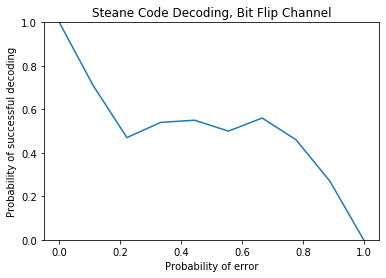

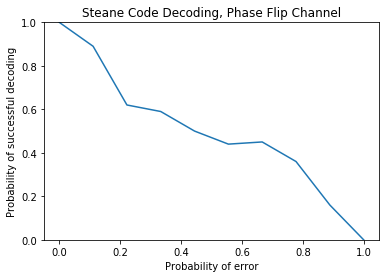

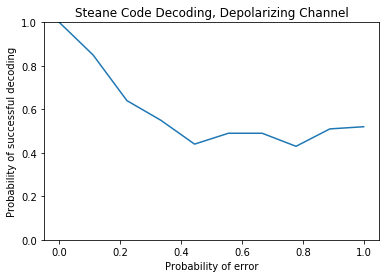

In [19]:
def bit_flip_channel(prob):
    return [np.sqrt(1-prob) * np.asarray([[1, 0], [0, 1]]), np.sqrt(prob) * np.asarray([[0, 1], [1, 0]])]

def phase_flip_channel(prob):
    return [np.sqrt(1 - prob) * np.eye(2), np.sqrt(prob) * np.asarray([[1,0],[0,-1]])]

def depolarizing_channel(prob):
    return [np.sqrt(1 - prob) * np.eye(2), np.sqrt(prob / 3) * np.asarray([[0, 1], [1, 0]]), np.sqrt(prob / 3) * np.asarray([[0, -1j], [1j, 0]]), np.sqrt(prob / 3) * np.asarray([[1,0],[0,-1]])]

def run_code(kraus_ops, basis_transform, trials):
    gate, inverse_gate = basis_transform
    prog = Program()
    ro = prog.declare("ro", "BIT")
    noise_data = Program()
    for qubit in range(7):
        noise_data.define_noisy_gate("I", [qubit], kraus_ops)
    prog = noise_data + prog
    orig = QubitPlaceholder()
    prog += gate(orig)
    logical = LogicalQubit()
    prog += logical.encode(orig)
    prog += logical.apply_error()
    prog += logical.correct()
    p, decoded = logical.decode()
    prog += p
    prog += inverse_gate(decoded)
    prog += MEASURE(decoded, ro)
    outputs = qvm.run(address_qubits(prog), trials=trials)
    return 1 - np.sum(outputs) / trials


success_rate = []
for error_prob in np.linspace(0, 1, 10):
    success_rate.append(run_code(bit_flip_channel(error_prob), (I,I), 100))
plt.plot(np.linspace(0, 1, 10), success_rate)
plt.title("Steane Code Decoding, Bit Flip Channel")
plt.xlabel("Probability of error")
plt.ylabel("Probability of successful decoding")
plt.ylim(0, 1)
plt.show()

success_rate = []
for error_prob in np.linspace(0, 1, 10):
    success_rate.append(run_code(phase_flip_channel(error_prob), (lambda q: RY(np.pi/2, q),
                                                                  lambda q: RY(-np.pi/2, q)), 100))
plt.plot(np.linspace(0, 1, 10), success_rate)
plt.title("Steane Code Decoding, Phase Flip Channel")
plt.xlabel("Probability of error")
plt.ylabel("Probability of successful decoding")
plt.ylim(0, 1)
plt.show()

success_rate = []
for error_prob in np.linspace(0, 1, 10):
    success_rate.append(run_code(depolarizing_channel(error_prob), (I, I), 100))
plt.plot(np.linspace(0, 1, 10), success_rate)
plt.title("Steane Code Decoding, Depolarizing Channel")
plt.xlabel("Probability of error")
plt.ylabel("Probability of successful decoding")
plt.ylim(0, 1)
plt.show()

### State Tomography Test
This encodes a state in a qubit, encodes it, and tests whether error correction can recover the original state after a single qubit error (in this case a bit flip) is applied.

In [33]:
from pyquil.quilbase import Qubit
from pyquil.operator_estimation import measure_observables
# Over-write full quilc compilation with a much more simple
# version that *only* substitutes gates to Rigetti-native gates.
# We don't want to accidentally compile away our tomography circuit
# or map to different qubits.
from forest.benchmarking.compilation import basic_compile
qc.compiler.quil_to_native_quil = basic_compile
from forest.benchmarking.tomography import generate_state_tomography_experiment
from forest.benchmarking.tomography import linear_inv_state_estimate

from grove.alpha.arbitrary_state.arbitrary_state import create_arbitrary_state

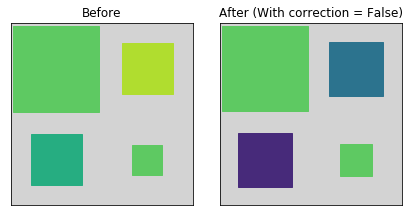

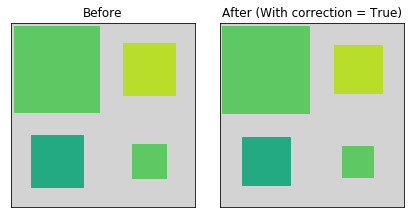

In [43]:
# should error correction be applied?
for correct in [False,True]:

    # create program with a qubit in some state to encode
    before = Program()
    q = QubitPlaceholder()

    # set qubit
    before += create_arbitrary_state(np.array([1+1j,0.5]), [q])

    # create duplicate program to test error correction
    after = before.copy()

    # encode qubit as logical qubit
    lq = LogicalQubit()
    after += lq.encode(q)

    # induce error on a single qubit
    single_qubit = lq.register[2]
    after += Z(single_qubit)

    # correct error
    if correct:
        after += lq.correct() # comment out to test without error correction

    # read logical qubit to single qubit
    p, q = lq.decode()
    after += p

    # address qubits
    def modify_qubit_mapping(partial_mapping, default_mapping):
        missing_qubits = [qubit for qubit in default_mapping.keys() if qubit not in partial_mapping.keys()] 
        missing_values = [value for value in default_mapping.values() if value not in partial_mapping.values()]
        return {**partial_mapping, **dict(zip(missing_qubits, missing_values))}

    before_qubit_mapping = modify_qubit_mapping({q: Qubit(0)}, get_default_qubit_mapping(before))
    after_qubit_mapping = modify_qubit_mapping({q: Qubit(0)}, get_default_qubit_mapping(after))

    # set relavent qubit addresses to 0
    before = address_qubits(before, qubit_mapping=before_qubit_mapping)
    after = address_qubits(after, qubit_mapping=after_qubit_mapping)


    before_experiment = generate_state_tomography_experiment(program=before, qubits=[0])
    after_experiment = generate_state_tomography_experiment(program=after, qubits=[0])


    qc = get_qc('14q-qvm')

    before_results = list(measure_observables(qc=qc, tomo_experiment=before_experiment, n_shots=100))
    after_results = list(measure_observables(qc=qc, tomo_experiment=after_experiment, n_shots=100))

    before_rho = linear_inv_state_estimate(before_results, qubits=[0])

    after_rho = linear_inv_state_estimate(after_results, qubits=[0])

    from matplotlib import pyplot as plt
    from forest.benchmarking.plotting import hinton
    fig, (ax1, ax2) = plt.subplots(1, 2)
    hinton(before_rho, ax=ax1)
    hinton(after_rho, ax=ax2)
    ax1.set_title('Before')
    ax2.set_title('After (With correction = {})'.format(correct))
    fig.tight_layout()

## E91 Quantum Key Distribution Protocol
### Without Error Correction

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
25
30


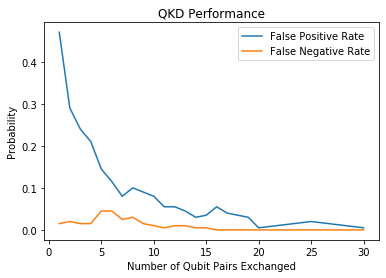

In [48]:
def generate_pair():
    pair = [QubitPlaceholder(), QubitPlaceholder()]
    prog = Program()
    prog += H(pair[0])
    prog += CNOT(pair[0], pair[1])
    return prog, pair

def measure_a(qubit, register):
    basis = np.random.choice([0, 1, 2])
    if basis == 0:
        return Program(MEASURE(qubit, register)), basis
    if basis == 1:
        p = Program()
        p += RY(angle=-np.pi / 4, qubit=qubit)
        p += MEASURE(qubit, register)
        return p, basis
    if basis == 2:
        p = Program()
        p += RY(angle=-np.pi / 2, qubit=qubit)
        p += MEASURE(qubit, register)
        return p, basis

def measure_b(qubit, register):
    basis = np.random.choice([1, 2, 3])
    if basis == 1:
        p = Program()
        p += RY(angle=-np.pi / 4, qubit=qubit)
        p += MEASURE(qubit, register)
        return p, basis
    if basis == 2:
        p = Program()
        p += RY(angle=-np.pi / 2, qubit=qubit)
        p += MEASURE(qubit, register)
        return p, basis
    if basis == 3:
        p = Program()
        p += RY(angle=-3 * np.pi / 4, qubit=qubit)
        p += MEASURE(qubit, register)
        return p, basis

def measure_e(pair, register):
    p, _ = measure_b(pair[1], register)
    pair[1] = QubitPlaceholder()
    return p

def get_sequences(key_len, eavesdrop):
    alice_bases = []
    bob_bases = []
    alice_received = []
    bob_received = []
    for _ in range(round(9 * key_len / 2)):
        prog = Program()
        #alice = prog.declare('alice', 'BIT', 1)
        #bob = prog.declare('bob', 'BIT', 1)
        measured = prog.declare('ro', 'BIT', 3)
        p, pair = generate_pair()
        prog += p
        if eavesdrop:
            p += measure_e(pair, measured)
        p_a, basis_a = measure_a(pair[0], measured[0])
        p_b, basis_b = measure_b(pair[1], measured[1])
        prog += p_a
        prog += p_b

        bits = qvm.run(address_qubits(prog), trials=1)[0]
        alice_bases.append(basis_a)
        bob_bases.append(basis_b)
        alice_received.append(bits[0])
        bob_received.append(bits[1])
    return np.asarray(alice_bases), np.asarray(bob_bases), np.asarray(alice_received), np.asarray(bob_received)

def correlation(obs1, obs2, bases1, bases2, i, j):
    match1 = np.nonzero(bases1 == i)
    match2 = np.nonzero(bases2 == j)
    matches = np.intersect1d(match1, match2)
    e1 = np.sum(np.logical_not(np.logical_xor(obs1[matches],  obs2[matches])))
    e2 = np.sum(np.logical_xor(obs1[matches],  obs2[matches]))
    return (e1 - e2) / (e1 + e2) if matches.shape[0] > 0 else 0

def verify(obs1, obs2, bases1, bases2):
    S = correlation(obs1, obs2, bases1, bases2, 0, 1)
    S -= correlation(obs1, obs2, bases1, bases2, 0, 3)
    S += correlation(obs1, obs2, bases1, bases2, 2, 1)
    S += correlation(obs1, obs2, bases1, bases2, 2, 3)
    #print(S)
    return S > 2

def generate_key(key_len, eavesdrop=False):
    alice_bases, bob_bases, alice_received, bob_received = get_sequences(key_len, eavesdrop)
    matching = (alice_bases == bob_bases)
    alice_key = alice_received[matching]
    bob_key = bob_received[matching]
    secure = verify(alice_received, bob_received, alice_bases, bob_bases)
    #assert (alice_key == bob_key).all()
    return alice_key, bob_key, secure

trial_sizes = list(range(1, 21))
trial_sizes.extend([25, 30]) #40, 50])#, 75, 100, 150, 200])
false_poss = []
false_negs = []
for num in trial_sizes:
    print(num)
    false_neg = 0
    false_pos = 0
    for _ in range(100):
        _, _, secure = generate_key(num, False)
        if not secure:
            false_pos += 1
        _, _, secure = generate_key(num, True)
        if secure:
            false_neg += 1
    false_poss.append(false_pos / 200)
    false_negs.append(false_neg / 200)

plt.plot(trial_sizes, false_poss, label="False Positive Rate")
plt.plot(trial_sizes, false_negs, label="False Negative Rate")
plt.legend()
plt.title("QKD Performance")
plt.xlabel("Number of Qubit Pairs Exchanged")
plt.ylabel("Probability")
plt.show()

## With Error Correction

In [ ]:
def transverse(qubit, gate):
    prog = Program()
    for i in range(7):
        prog += gate(qubit.register[i])
    return prog

def logical_RY(qubit, angle):
    prog = Program()
    for i in range(7):
        prog += RY(angle, qubit.register[i])
    return prog

def logical_CNOT(qubit1, qubit2):
    prog = Program()
    for i in range(7):
        prog += CNOT(qubit1.register[i], qubit2.register[i])
    return prog

def generate_pair():
    pair = [LogicalQubit(), LogicalQubit()]
    pair[0].encode(QubitPlaceholder())
    pair[1].encode(QubitPlaceholder())
    prog = Program()
    prog += transverse(pair[0], H)
    prog += logical_CNOT(pair[0], pair[1])
    return prog, pair

def measure_a(qubit, register):
    basis = np.random.choice([0, 1, 2])
    if basis == 0:
        p, decoded = qubit.decode()
        p += MEASURE(decoded, register)
        return Program(MEASURE(decoded, register)), basis
    if basis == 1:
        p = Program()
        p += logical_RY(angle=-np.pi / 8, qubit=qubit)
        p1, decoded = qubit.decode()
        p += p1
        p += MEASURE(decoded, register)
        return p, basis
    if basis == 2:
        p = Program()
        p += logical_RY(angle=-np.pi / 4, qubit=qubit)
        p1, decoded = qubit.decode()
        p += p1
        p += MEASURE(decoded, register)
        return p, basis

def measure_b(qubit, register):
    basis = np.random.choice([1, 2, 3])
    if basis == 1:
        p = Program()
        p += logical_RY(angle=-np.pi / 8, qubit=qubit)
        p1, decoded = qubit.decode()
        p += p1
        p += MEASURE(decoded, register)
        return p, basis
    if basis == 2:
        p = Program()
        p += logical_RY(angle=-np.pi / 4, qubit=qubit)
        p1, decoded = qubit.decode()
        p += p1
        p += MEASURE(decoded, register)
        return p, basis
    if basis == 3:
        p = Program()
        p += logical_RY(angle=-3 * np.pi / 8, qubit=qubit)
        p1, decoded = qubit.decode()
        p += p1
        p += MEASURE(decoded, register)
        return p, basis

def measure_e(pair, register):
    p, _ = measure_b(pair[1], register)
    pair[1] = LogicalQubit()
    pair[1].encode(QubitPlaceholder())
    return p

def get_sequences(key_len, kraus_ops, eavesdrop):
    alice_bases = []
    bob_bases = []
    alice_received = []
    bob_received = []
    noise_data = Program()
    if kraus_ops is not None:
        for qubit in range(26):
            noise_data.define_noisy_gate("I", [qubit], kraus_ops)
    for _ in range(round(9 * key_len / 2)):
        prog = Program()
        prog += noise_data
        measured = prog.declare('ro', 'BIT', 3)
        p, pair = generate_pair()
        prog += p
        if eavesdrop:
            p += measure_e(pair, measured)
        p_a, basis_a = measure_a(pair[0], measured[0])
        p_b, basis_b = measure_b(pair[1], measured[1])
        prog += p_a
        prog += p_b

        bits = qvm.run(address_qubits(prog), trials=1)[0]
        alice_bases.append(basis_a)
        bob_bases.append(basis_b)
        alice_received.append(bits[0])
        bob_received.append(bits[1])
    return np.asarray(alice_bases), np.asarray(bob_bases), np.asarray(alice_received), np.asarray(bob_received)

def correlation(obs1, obs2, bases1, bases2, i, j):
    match1 = np.nonzero(bases1 == i)
    match2 = np.nonzero(bases2 == j)
    matches = np.intersect1d(match1, match2)
    e1 = np.sum(np.logical_not(np.logical_xor(obs1[matches],  obs2[matches])))
    e2 = np.sum(np.logical_xor(obs1[matches],  obs2[matches]))
    return (e1 - e2) / (e1 + e2) if matches.shape[0] > 0 else 0

def verify(obs1, obs2, bases1, bases2):
    S = correlation(obs1, obs2, bases1, bases2, 0, 1)
    S -= correlation(obs1, obs2, bases1, bases2, 0, 3)
    S += correlation(obs1, obs2, bases1, bases2, 2, 1)
    S += correlation(obs1, obs2, bases1, bases2, 2, 3)
    print(S)
    return S > 2

def generate_key(key_len, kraus_ops=None, eavesdrop=False):
    alice_bases, bob_bases, alice_received, bob_received = get_sequences(key_len, kraus_ops, eavesdrop)
    matching = (alice_bases == bob_bases)
    alice_key = alice_received[matching]
    bob_key = bob_received[matching]
    secure = verify(alice_received, bob_received, alice_bases, bob_bases)
    assert (alice_key == bob_key).all()
    return alice_key, bob_key, secure